<a href="https://colab.research.google.com/github/saymrwulf/timeseries/blob/main/oho_yfinance_neural_forecasting_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepwork

In [10]:
!pip install yfinance neuralforecast
!pip install statsforecast ray

In [11]:
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoAutoformer, AutoPatchTST, AutoiTransformer, AutoFEDformer
from neuralforecast.losses.pytorch import MQLoss
from ray import tune
import yfinance as yf

In [12]:
data = yf.download("AAPL", start="2015-01-01", end="2023-06-30")
data
aapl = yf.Ticker('AAPL')
aapl.balance_sheet

[*********************100%***********************]  1 of 1 completed


,2024-09-30,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Treasury Shares Number,NaN,0.0,NaN,NaN,NaN
Ordinary Shares Number,15116786000.0,15550061000.0,15943425000.0,16426786000.0,NaN
Share Issued,15116786000.0,15550061000.0,15943425000.0,16426786000.0,NaN
Net Debt,76686000000.0,81123000000.0,96423000000.0,89779000000.0,NaN
Total Debt,106629000000.0,111088000000.0,132480000000.0,136522000000.0,NaN
...,...,...,...,...,...
Cash Cash Equivalents And Short Term Investments,65171000000.0,61555000000.0,48304000000.0,62639000000.0,NaN
Other Short Term Investments,35228000000.0,31590000000.0,24658000000.0,27699000000.0,NaN
Cash And Cash Equivalents,29943000000.0,29965000000.0,23646000000.0,34940000000.0,NaN
Cash Equivalents,2744000000.0,1606000000.0,5100000000.0,17635000000.0,NaN


In [13]:
import pandas as pd

# Fetch data for multiple tickers
tickers = ["AAPL", "GOOG", "MSFT"]
data = yf.download(tickers, start="2015-01-01", end="2023-06-30")

# Reshape the data
df = data['Close']  # No need to unstack here

# Convert the Series to a DataFrame if it's not already (optional but recommended)
if isinstance(df, pd.Series):
    df = df.to_frame()

# Melt the dataframe to long format
hist = df.melt(ignore_index=False, var_name='Ticker', value_name='Close')
hist.reset_index(inplace=True)

print(hist)
hist.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'Close':'y'}, inplace=True)
hist.head()

[*********************100%***********************]  3 of 3 completed

           Date Ticker       Close
0    2015-01-02   AAPL   27.332500
1    2015-01-05   AAPL   26.562500
2    2015-01-06   AAPL   26.565001
3    2015-01-07   AAPL   26.937500
4    2015-01-08   AAPL   27.972500
...         ...    ...         ...
6406 2023-06-23   MSFT  335.019989
6407 2023-06-26   MSFT  328.600006
6408 2023-06-27   MSFT  334.570007
6409 2023-06-28   MSFT  335.850006
6410 2023-06-29   MSFT  335.049988

[6411 rows x 3 columns]


,ds,unique_id,y
0,2015-01-02,AAPL,27.332500
1,2015-01-05,AAPL,26.562500
2,2015-01-06,AAPL,26.565001
3,2015-01-07,AAPL,26.937500
4,2015-01-08,AAPL,27.972500


# Training & Prediction AutoNHITS & AutoAutoFormer

In [ ]:
!pip install statsforecast ray

In [83]:
import neuralforecast.losses.pytorch as NFL
print(dir(NFL))

['Accuracy', 'AffineTransform', 'BaseISQF', 'BasePointLoss', 'Bernoulli', 'Beta', 'Distribution', 'DistributionLoss', 'F', 'GMM', 'HuberLoss', 'HuberMQLoss', 'HuberQLoss', 'IQLoss', 'ISQF', 'MAE', 'MAPE', 'MASE', 'MQLoss', 'MSE', 'NBMM', 'NegativeBinomial', 'Normal', 'Optional', 'PMM', 'Poisson', 'QuantileLayer', 'QuantileLoss', 'RMSE', 'SMAPE', 'StudentT', 'TransformedDistribution', 'TukeyLoss', 'Tuple', 'Tweedie', 'Union', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_divide_no_nan', '_weighted_mean', 'bernoulli_domain_map', 'bernoulli_scale_decouple', 'constraints', 'est_alpha', 'est_beta', 'est_lambda', 'isqf_domain_map', 'isqf_scale_decouple', 'level_to_outputs', 'math', 'nbinomial_domain_map', 'nbinomial_scale_decouple', 'nn', 'normal_domain_map', 'normal_scale_decouple', 'np', 'partial', 'poisson_domain_map', 'poisson_scale_decouple', 'quantiles_to_outputs', 'relMSE', 'sCRPS', 'student_domain_map', 'student

In [84]:
from neuralforecast.auto import AutoNHITS, AutoAutoformer
from neuralforecast.losses.pytorch import MQLoss, HuberLoss
from ray import tune

In [60]:
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_autoformer = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_layers": tune.choice([2,4]),                     # Number of layers in Autoformer
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}

2025-01-09 11:59:21,907	INFO worker.py:1654 -- Calling ray.init() again after it has already been called.


[INFO] Starting nf.fit(...) with Ray Tune. If you see no progress logs, check Ray's output cells.
Quick Mode = True. Time limit = 120 sec.



TypeError: NeuralForecast.fit() got an unexpected keyword argument 'stop'

In [38]:
nf = NeuralForecast(
    models=[
        AutoAutoformer(h=48, config=config_autoformer, loss=MQLoss(), num_samples=2),
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
    ],
    freq='D' # hourly ?!
)
nf.fit(df=hist)

+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2025-01-08_17-24-15   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2025-01-08_17-24-15
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-08_12-39-14_441571_687/artifacts/2025-01-08_17-24-15/_train_tune_2025-01-08_17-24-15/driver_artifacts`


2025-01-08 17:24:16,973	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-01-08 17:24:16,983	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-01-08_17-24-15' in 0.0038s.


KeyboardInterrupt: 

### Prediction

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

In [ ]:
print("Forecast Data Unique IDs:", fcst_df['unique_id'].unique())
print("Forecast DataFrame columns:", fcst_df.columns)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

this_ticker = "AAPL"

# Filter historical data for just this ticker
hist_one = hist[hist['unique_id'] == this_ticker].copy()

# Filter the forecast data
fcst_one = fcst_df[fcst_df['unique_id'] == this_ticker].copy()

# Merge them on ['unique_id', 'ds']
df_merge = pd.merge(hist_one, fcst_one, on=['unique_id', 'ds'], how='outer')
df_merge.sort_values('ds', inplace=True)

plt.figure(figsize=(10,5), dpi=80)

# Plot the actual series
plt.plot(df_merge['ds'], df_merge['y'], label='Actual', linewidth=2)

# Plot AutoAutoformer
plt.plot(df_merge['ds'], df_merge['AutoAutoformer'],
	label='AutoAutoformer (median)', linestyle='--')
plt.fill_between(
	df_merge['ds'],
	df_merge['AutoAutoformer-lo-90'],
	df_merge['AutoAutoformer-hi-90'],
	alpha=0.2,
	label='AutoAutoformer (90% CI)'
)

# Plot AutoNHITS
plt.plot(df_merge['ds'], df_merge['AutoNHITS'],
	label='AutoNHITS (median)', linestyle='--')
plt.fill_between(
	df_merge['ds'],
	df_merge['AutoNHITS-lo-90'],
	df_merge['AutoNHITS-hi-90'],
	alpha=0.2,
	label='AutoNHITS (90% CI)'
)

plt.title(f'Forecast vs. Actual for {this_ticker}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import datetime as dt

# 1) Figure out the cutoff date, 100 days before the max 'ds'
cutoff = df_merge['ds'].max() - dt.timedelta(days=100)

# 2) Filter to only show data after (or on) that date
df_merge_100d = df_merge[df_merge['ds'] >= cutoff].copy()

# 3) Plot the same lines/confidence intervals
plt.figure(figsize=(10,5), dpi=80)
plt.plot(df_merge_100d['ds'], df_merge_100d['y'], label='Actual', linewidth=2)

# Plot AutoAutoformer
plt.plot(df_merge_100d['ds'], df_merge_100d['AutoAutoformer'],
	label='AutoAutoformer (median)', linestyle='--')
plt.fill_between(
	df_merge_100d['ds'],
	df_merge_100d['AutoAutoformer-lo-90'],
	df_merge_100d['AutoAutoformer-hi-90'],
	alpha=0.2,
	label='AutoAutoformer (90% CI)'
)

# Plot AutoNHITS
plt.plot(df_merge_100d['ds'], df_merge_100d['AutoNHITS'],
	label='AutoNHITS (median)', linestyle='--')
plt.fill_between(
	df_merge_100d['ds'],
	df_merge_100d['AutoNHITS-lo-90'],
	df_merge_100d['AutoNHITS-hi-90'],
	alpha=0.2,
	label='AutoNHITS (90% CI)'
)

plt.title('Forecast vs. Actual (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Suppose this is your last known historical date
last_hist_date = hist_one['ds'].max()

# Filter df_merge to only show forecast dates
df_fcst_only = df_merge[df_merge['ds'] > last_hist_date].copy()

# Plot
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(df_fcst_only['ds'], df_fcst_only['AutoAutoformer'], label='AutoAutoformer', linestyle='--')
plt.fill_between(
	df_fcst_only['ds'],
	df_fcst_only['AutoAutoformer-lo-90'],
	df_fcst_only['AutoAutoformer-hi-90'],
	alpha=0.2, label='AutoAutoformer (90% CI)'
)

plt.plot(df_fcst_only['ds'], df_fcst_only['AutoNHITS'], label='AutoNHITS', linestyle='--')
plt.fill_between(
	df_fcst_only['ds'],
	df_fcst_only['AutoNHITS-lo-90'],
	df_fcst_only['AutoNHITS-hi-90'],
	alpha=0.2, label='AutoNHITS (90% CI)'
)

plt.title('Forecast Period Only')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prediction Perfomance Advanced (with Buy-Sell-Hold)

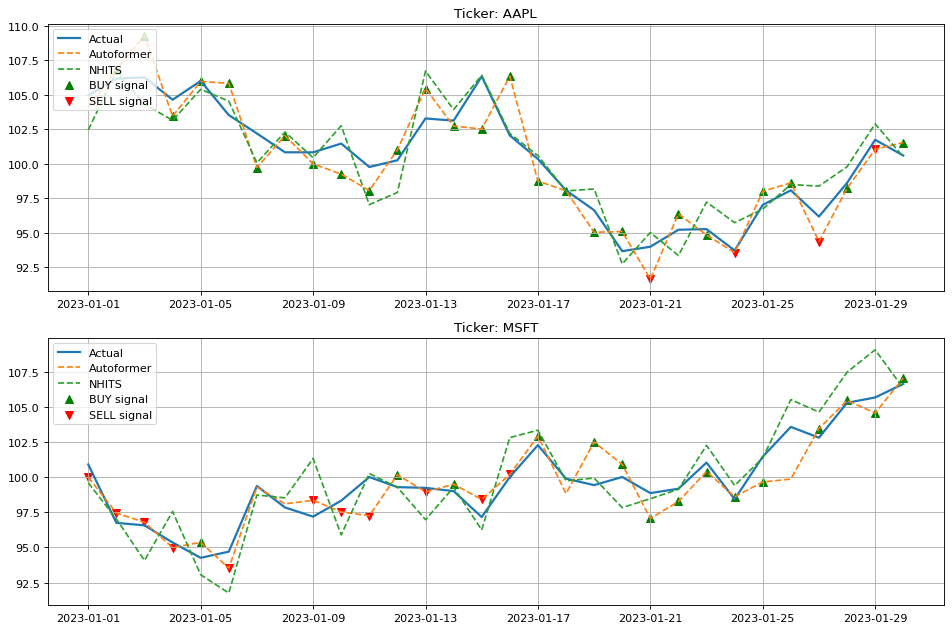

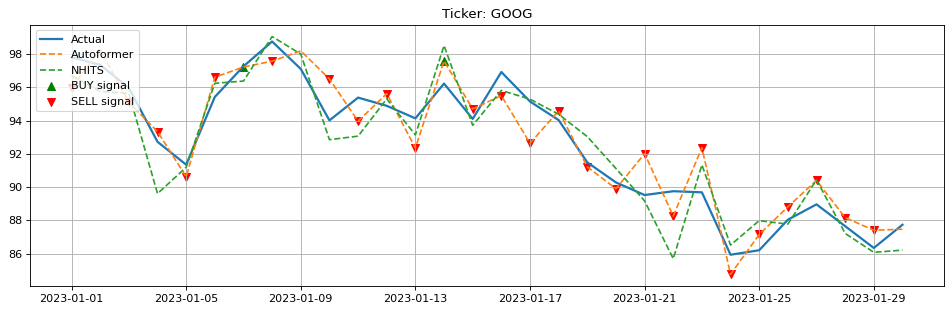

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def naive_signal(df, forecast_col='Autoformer', threshold=0.5):
    """
    Given a DataFrame `df` with columns 'ds' and a forecast column (e.g. 'Autoformer'),
    compute the day-to-day difference in forecast and return a naive Buy/Sell/Hold signal
    based on a threshold.
    """
    # Sort by ds to ensure correct temporal ordering
    df = df.sort_values('ds').copy()

    # Compute day-to-day difference in the forecast
    df['forecast_diff'] = df[forecast_col].diff()

    # Conditions
    cond_buy  = df['forecast_diff'] > threshold
    cond_sell = df['forecast_diff'] < -threshold

    # np.select for 3-state logic
    df['Signal'] = np.select(
        [cond_buy, cond_sell],
        ['BUY', 'SELL'],
        default='HOLD'
    )
    return df

def plot_in_subplots(fcst_df, model_cols, max_per_page=4, dpi=80):
    """
    Create subplots for up to `max_per_page` tickers at a time, plotting
    actual data vs. multiple forecast model columns, plus optional signals.

    fcst_df must have columns:
      - 'unique_id' (ticker)
      - 'ds' (date/time)
      - 'y' (actual)
      - each forecast model in `model_cols`
      - optionally 'Signal' for buy/hold/sell (plotting is up to you)
    """
    unique_ids = fcst_df['unique_id'].unique()
    n_tickers = len(unique_ids)

    start_idx = 0
    while start_idx < n_tickers:
        end_idx = min(start_idx + max_per_page, n_tickers)
        page_ids = unique_ids[start_idx:end_idx]

        fig, axes = plt.subplots(len(page_ids), 1,
                                 figsize=(12, 4 * len(page_ids)),
                                 dpi=dpi, sharex=False)

        # If there's only 1 row
        if len(page_ids) == 1:
            axes = [axes]

        for ax, uid in zip(axes, page_ids):
            df_one = fcst_df.loc[fcst_df['unique_id'] == uid].copy()
            df_one.sort_values('ds', inplace=True)

            # Plot actual
            ax.plot(df_one['ds'], df_one['y'], label='Actual', linewidth=2)

            # Plot each model
            for mc in model_cols:
                if mc in df_one.columns:
                    ax.plot(df_one['ds'], df_one[mc], label=mc, linestyle='--')

            # (Optional) If we have a 'Signal' column, we can annotate:
            if 'Signal' in df_one.columns:
                # Example: mark each BUY date with a green arrow, SELL with red arrow
                # This is just a quick example of how to annotate.
                buys = df_one[df_one['Signal'] == 'BUY']
                sells = df_one[df_one['Signal'] == 'SELL']
                ax.scatter(buys['ds'], buys[model_cols[0]], marker='^', color='green', s=50, label='BUY signal')
                ax.scatter(sells['ds'], sells[model_cols[0]], marker='v', color='red', s=50, label='SELL signal')

            ax.set_title(f"Ticker: {uid}")
            ax.grid(True)
            ax.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

        start_idx = end_idx

# --- SAMPLE DATA SETUP ---
# In real usage, you'd have your actual fcst_df from Nixtla: columns = [unique_id, ds, y, Autoformer, NHITS, ...]

# For demonstration, let's build minimal “fake” data:
dates = pd.date_range(start='2023-01-01', periods=30, freq='D')
tickers = ['AAPL', 'GOOG', 'MSFT']
rows = []
for tkr in tickers:
    # Generate a simple 'y' with random walk
    y_values = 100 + np.cumsum(np.random.randn(len(dates))) * 2
    # Generate 2 forecast columns with slight variations
    autoformer_vals = y_values + np.random.randn(len(dates)) * 1.5
    nhits_vals = y_values + np.random.randn(len(dates)) * 1.5

    for d, yv, afv, nhv in zip(dates, y_values, autoformer_vals, nhits_vals):
        rows.append((tkr, d, yv, afv, nhv))

fcst_df_example = pd.DataFrame(rows, columns=['unique_id', 'ds', 'y', 'Autoformer', 'NHITS'])

# (Optional) Compute signals on one of the model columns:
fcst_df_example = naive_signal(fcst_df_example, forecast_col='Autoformer', threshold=1.0)

# Plot them in subplots
plot_in_subplots(
    fcst_df=fcst_df_example,
    model_cols=['Autoformer', 'NHITS'],
    max_per_page=2,  # Show 2 tickers per “page”
    dpi=80
)

# --- END CELL ---

# M6 Metrics

/usr/local/lib/python3.10/dist-packages/utilsforecast/processing.py:384: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<ipython-input-30-36ad030c21d2>:109: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-30-36ad030c21d2>:109: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-30-36ad030c21d2>:109: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either p

IN-SAMPLE predictions from NF:
  unique_id         ds              cutoff  AutoAutoformer-median  \
0      AAPL 2015-02-09 2015-02-08 23:00:00               0.725111   
1      AAPL 2015-02-10 2015-02-08 23:00:00               0.720327   
2      AAPL 2015-02-11 2015-02-08 23:00:00               0.719755   
3      AAPL 2015-02-12 2015-02-08 23:00:00               0.723274   
4      AAPL 2015-02-13 2015-02-08 23:00:00               0.733378   
5      AAPL 2015-02-17 2015-02-08 23:00:00               0.756905   
6      AAPL 2015-02-18 2015-02-08 23:00:00               0.804936   
7      AAPL 2015-02-19 2015-02-08 23:00:00               0.869861   
8      AAPL 2015-02-20 2015-02-08 23:00:00               0.913256   
9      AAPL 2015-02-23 2015-02-08 23:00:00               0.928619   

   AutoAutoformer-lo-90  AutoAutoformer-lo-80  AutoAutoformer-hi-80  \
0             -0.885759             -0.253195              1.508279   
1             -0.892432             -0.239096              1.503273

<ipython-input-30-36ad030c21d2>:109: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-30-36ad030c21d2>:109: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-30-36ad030c21d2>:109: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either p

AutoNHITS-hi-80     |  224.353     9.791    13.089    -0.043
AutoNHITS-hi-90     |  295.158    11.637    14.736    -0.018
Naive               |  189.622     9.253     9.014    -0.020


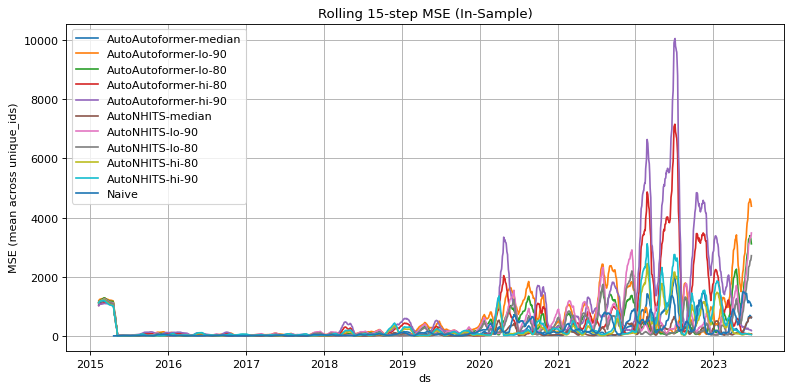

In [30]:
###################################################
# Compare AutoAutoformer, AutoNHITS, vs. Naive
# USING IN-SAMPLE PREDICTIONS to avoid empty merges
###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

###############################
# 1) CALL nf.predict_insample(...) INSTEAD OF nf.predict()
###############################
# Example:
#    horizon = 48    # or 12, or 24, etc.
#    step_size = horizon
#    fcst_insample = nf.predict_insample(step_size=step_size)
#
# Make sure your nf object is fitted: nf.fit(hist)
# And that freq=... matches your actual data.
###############################
horizon = 48  # or adjust as needed
step_size = horizon
fcst_insample = nf.predict_insample(step_size=step_size)

# If it’s a MultiIndex, flatten it
if isinstance(fcst_insample.index, pd.MultiIndex):
    fcst_insample = fcst_insample.reset_index()

print("IN-SAMPLE predictions from NF:")
print(fcst_insample.head(10))

###############################
# 2) Build a naive baseline for the SAME in-sample timestamps
###############################
def make_naive_in_sample(df: pd.DataFrame, horizon: int=48) -> pd.DataFrame:
    """
    For each unique_id's time series, create an in-sample naive forecast by
    shifting 'y' down by 'horizon' steps. That means the naive forecast at time t
    is just the actual value at time t - horizon.
    """
    # Expect columns: [unique_id, ds, y, ...]
    all_out = []
    for uid, g in df.groupby('unique_id', group_keys=False):
        g = g.sort_values('ds').copy()
        g['Naive'] = g['y'].shift(horizon)
        all_out.append(g)
    return pd.concat(all_out).sort_values(['unique_id','ds'])

###############################
# 2a) We must *also* have the same columns in fcst_insample
#     Typically, nf.predict_insample returns: [unique_id, ds, y, <model cols> ...]
###############################
# Ensure we have columns named "unique_id", "ds", "y"
if not {'unique_id','ds','y'}.issubset(fcst_insample.columns):
    raise ValueError("Your fcst_insample lacks some of [unique_id, ds, y]. "
                     "Check nf.predict_insample output columns.")

# Create naive
df_naive = make_naive_in_sample(fcst_insample, horizon=horizon)

###############################
# 3) Merge the naive forecast column into fcst_insample
###############################
df_eval = fcst_insample.merge(
    df_naive[['unique_id','ds','Naive']],
    on=['unique_id','ds'],
    how='left'
)

print("\nMerged in-sample DataFrame (with naive baseline):")
print(df_eval.head())

# If STILL empty, it likely means your horizon is too large for your data length,
# so there's no overlap after shifting.
# Another cause is freq mismatch: if your data isn't actually 'H',
# you might not have consistent hourly steps.
# Adjust 'freq=...' or reduce horizon.

###############################
# 4) Compute metrics for each model + Naive
###############################
def smape(y_true, y_pred):
    return 100.0 * np.mean(2.0 * np.abs(y_true - y_pred)
                           / (np.abs(y_true) + np.abs(y_pred)))

def compute_metrics(df: pd.DataFrame, model_col: str) -> tuple:
    """ Return (MSE, MAE, sMAPE, SpearmanCorrOnReturns). """
    # Filter to rows with no missing
    sub = df.dropna(subset=['y', model_col])
    if len(sub) == 0:
        return (np.nan, np.nan, np.nan, np.nan)

    y_true = sub['y'].to_numpy()
    y_pred = sub[model_col].to_numpy()

    mse_  = mean_squared_error(y_true, y_pred)
    mae_  = mean_absolute_error(y_true, y_pred)
    smape_ = smape(y_true, y_pred)

    # Spearman on returns
    # We can't just do sub['y'].pct_change() globally, because sub has multiple series
    # So we group by unique_id
    sub = sub.sort_values(['unique_id','ds']).copy()
    def add_ret(g):
        g['ret_true'] = g['y'].pct_change()
        g['ret_pred'] = g[model_col].pct_change()
        return g
    sub = sub.groupby('unique_id', group_keys=False).apply(add_ret)

    # Drop rows where returns are NaN
    sub = sub.dropna(subset=['ret_true','ret_pred'])
    if len(sub) == 0:
        spear_ = np.nan
    else:
        spear_ = spearmanr(sub['ret_true'], sub['ret_pred']).correlation

    return mse_, mae_, smape_, spear_

models_in_df = [c for c in df_eval.columns if c.startswith('Auto') or c=='Naive']
print(f"\nFound these forecast columns: {models_in_df}")

print("\n--- In-sample Metrics Summary ---")
print("Model               |   MSE     MAE     sMAPE(%)   Spearman_R")

for mcol in models_in_df:
    mse_, mae_, smape_, spear_ = compute_metrics(df_eval, mcol)
    print(f"{mcol:20s}| {mse_:8.3f}  {mae_:8.3f}  {smape_:8.3f}    {spear_:.3f}")

###############################
# 5) Plot a rolling MSE vs time
###############################
def rolling_mse_over_time(df_input, model_col, window=30):
    """
    Combine all unique_ids, group by ds, compute mean squared error across tickers,
    then do a rolling(...) on ds. We'll do an integer-based rolling in sorted order.
    """
    sub = df_input.dropna(subset=['y', model_col]).copy()
    sub['err_sq'] = (sub['y'] - sub[model_col])**2

    # Average by ds
    daily = sub.groupby('ds', as_index=False)['err_sq'].mean().sort_values('ds')
    daily['rolling_mse'] = daily['err_sq'].rolling(window=window, min_periods=1).mean()
    daily['model'] = model_col
    return daily[['ds','model','rolling_mse']]

window_size = 15  # or 30, etc.

list_dfs = []
for mcol in models_in_df:
    temp = rolling_mse_over_time(df_eval, mcol, window=window_size)
    list_dfs.append(temp)

df_timeplot = pd.concat(list_dfs, ignore_index=True)

plt.figure(figsize=(10,5), dpi=80)
for mcol in models_in_df:
    sub = df_timeplot[df_timeplot['model'] == mcol]
    plt.plot(sub['ds'], sub['rolling_mse'], label=mcol)

plt.title(f"Rolling {window_size}-step MSE (In-Sample)")
plt.xlabel("ds")
plt.ylabel("MSE (mean across unique_ids)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- Overall Metrics Summary ---
Model          |   MSE       MAE      sMAPE(%)   Spearman_R
AutoNHITS     |    24.595     3.938       2.741        0.987
AutoAutoformer|    64.987     6.434       4.477        0.968
Naive         |    67.700     5.813       4.036        0.963
M6Champion    |     4.123     1.608       1.118        0.998
rollingMSE_AutoNHITS| 16619.440   125.242     143.061        0.044
rollingMSE_AutoAutoformer|  8646.669    85.736      80.558        0.009
rollingMSE_Naive| 298261.104   160.543     105.723       -0.106
rollingMSE_M6Champion| 22102.676   145.733     189.007        0.066


<ipython-input-35-9089ed5dc643>:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-35-9089ed5dc643>:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-35-9089ed5dc643>:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass

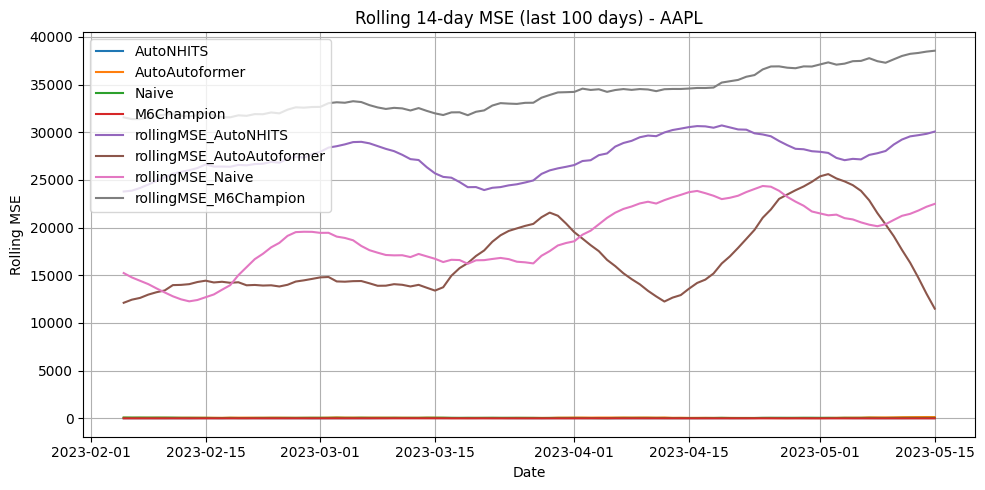


Winners per metric: {'Best_MSE': 'M6Champion', 'Best_MAE': 'M6Champion', 'Best_sMAPE': 'M6Champion', 'Best_Spearman': 'M6Champion'}


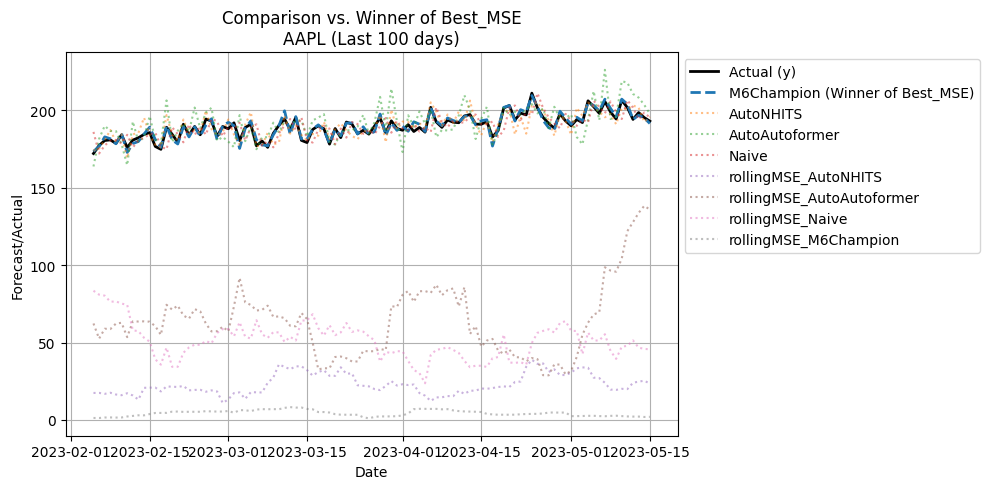

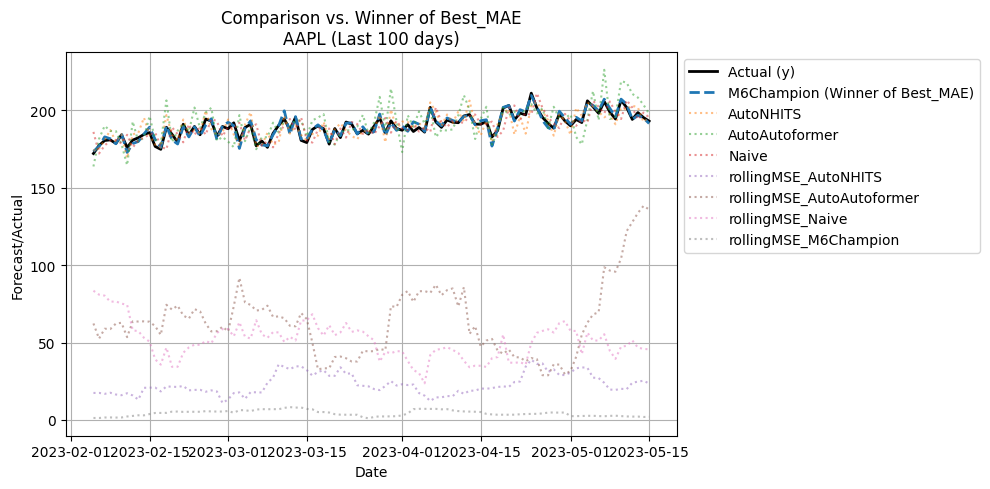

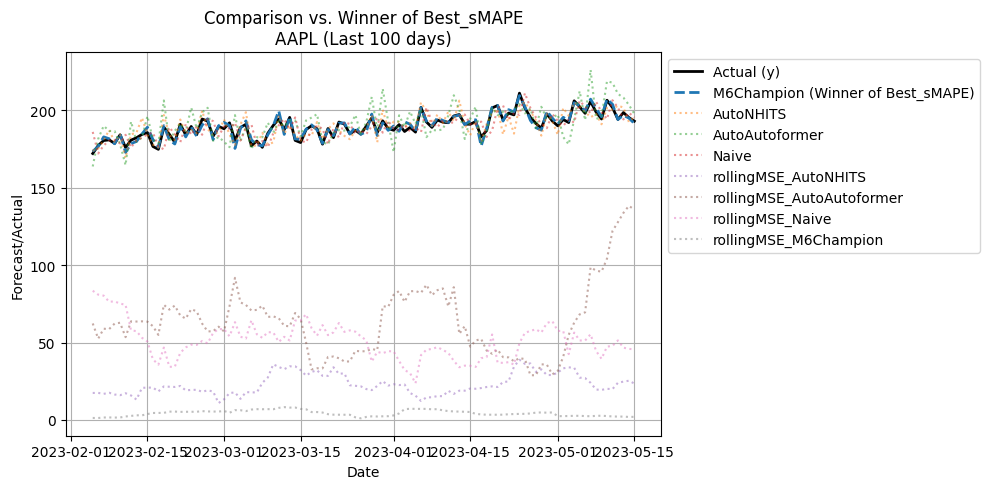

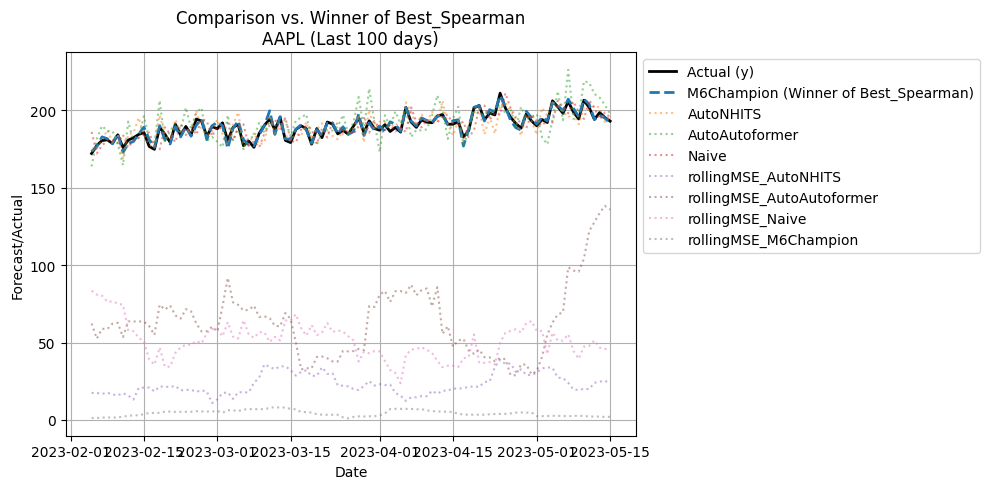

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

###############################################################################
# 0) We assume you already have df_eval: a DataFrame with columns at least:
#       ["unique_id", "ds", "y", ...one or more forecast columns...]
#    E.g. df_eval = pd.read_csv("my_forecast_evals.csv")
###############################################################################

# Quick check
required_cols = {"unique_id","ds","y"}
if not required_cols.issubset(df_eval.columns):
    raise ValueError(f"df_eval must contain at least {required_cols}.")

# Sort for consistent ordering
df_eval.sort_values(by=["unique_id", "ds"], inplace=True)

###############################################################################
# 1) Compute Metrics: MSE, MAE, sMAPE, Spearman R
###############################################################################
def compute_metrics(sub_df, model_col):
    """
    Given a sub-dataframe with columns ['y', model_col],
    compute MSE, MAE, sMAPE, and Spearman correlation.
    Return (mse, mae, smape, spearman_r).
    """
    y_true = sub_df['y'].values
    y_pred = sub_df[model_col].values

    # 1) MSE
    mse_ = np.mean((y_true - y_pred) ** 2)

    # 2) MAE
    mae_ = np.mean(np.abs(y_true - y_pred))

    # 3) sMAPE
    denom = np.abs(y_true) + np.abs(y_pred)
    smape_ = np.mean(
        np.where(denom != 0, 2.0 * np.abs(y_true - y_pred) / denom, 0)
    ) * 100

    # 4) Spearman correlation (directly on the series)
    try:
        corr, _ = spearmanr(y_true, y_pred)
    except ValueError:
        corr = np.nan

    return mse_, mae_, smape_, corr

###############################################################################
# 2) Summarize all models in a table
###############################################################################
# Identify model columns (everything except unique_id, ds, y)
skip_cols = {"unique_id", "ds", "y"}
model_cols = [c for c in df_eval.columns if c not in skip_cols]

metrics_result = []
for mcol in model_cols:
    sub = df_eval.dropna(subset=["y", mcol])
    if len(sub) == 0:
        print(f"[WARN] Model '{mcol}' has no valid rows (all NaN?), skipping.")
        continue
    mse_, mae_, smape_, spear_ = compute_metrics(sub, mcol)
    metrics_result.append((mcol, mse_, mae_, smape_, spear_))

# Print a summary table
print("\n--- Overall Metrics Summary ---")
print("Model          |   MSE       MAE      sMAPE(%)   Spearman_R")
for (mcol, mse_, mae_, smape_, spear_) in metrics_result:
    print(f"{mcol:14s}| {mse_:9.3f} {mae_:9.3f} {smape_:11.3f}   {spear_:10.3f}")

###############################################################################
# 3) Rolling MSE over time, ZOOM in on last 100 days
###############################################################################
ROLL_WINDOW = 14
ZOOM_DAYS = 100

def add_rolling_mse(df, model_col, window=14):
    """
    For each unique_id, compute the rolling MSE vs. y over 'window' rows.
    We'll store it in a new column: f'rollingMSE_{model_col}'.
    """
    def _roll_fn(sub):
        errs = (sub['y'] - sub[model_col])**2
        rolling_mse = errs.rolling(window=window, min_periods=1).mean()
        sub[f'rollingMSE_{model_col}'] = rolling_mse
        return sub

    return df.groupby("unique_id", group_keys=False).apply(_roll_fn)

# Compute rolling MSE for each model
for mcol in model_cols:
    df_eval = add_rolling_mse(df_eval, mcol, window=ROLL_WINDOW)

# For demonstration, pick one stock_of_interest
stock_of_interest = df_eval['unique_id'].iloc[0]  # or e.g. "AAPL"
# Zoom in on last ZOOM_DAYS for that stock
sub_stock = df_eval[df_eval['unique_id'] == stock_of_interest].copy()
sub_stock_zoom = sub_stock.iloc[-ZOOM_DAYS:].copy()

plt.figure(figsize=(10, 5))
for mcol in model_cols:
    colname = f'rollingMSE_{mcol}'
    if colname not in sub_stock_zoom.columns:
        continue
    plt.plot(sub_stock_zoom['ds'], sub_stock_zoom[colname], label=mcol)

plt.title(f"Rolling {ROLL_WINDOW}-day MSE (last {ZOOM_DAYS} days) - {stock_of_interest}")
plt.xlabel("Date")
plt.ylabel("Rolling MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###############################################################################
# 4) Separate charts for each metric's “winner”
###############################################################################
df_metrics = pd.DataFrame(metrics_result, columns=["model","mse","mae","smape","spearman"])
if len(df_metrics) > 0:
    best_mse_model    = df_metrics.loc[df_metrics['mse'].idxmin(),"model"]
    best_mae_model    = df_metrics.loc[df_metrics['mae'].idxmin(),"model"]
    best_smape_model  = df_metrics.loc[df_metrics['smape'].idxmin(),"model"]
    best_spear_model  = df_metrics.loc[df_metrics['spearman'].idxmax(),"model"]

    winners = {
        "Best_MSE"     : best_mse_model,
        "Best_MAE"     : best_mae_model,
        "Best_sMAPE"   : best_smape_model,
        "Best_Spearman": best_spear_model
    }
    print("\nWinners per metric:", winners)

    # We'll compare them in the last ZOOM_DAYS for stock_of_interest
    for metric_label, winner_name in winners.items():
        if winner_name not in model_cols:
            continue  # skip if some weird data
        plt.figure(figsize=(10, 5))
        # Plot actual y
        plt.plot(sub_stock_zoom['ds'], sub_stock_zoom['y'], label="Actual (y)", c='black', linewidth=2)

        # Plot the winner
        plt.plot(sub_stock_zoom['ds'], sub_stock_zoom[winner_name],
                 label=f"{winner_name} (Winner of {metric_label})",
                 linestyle='--', linewidth=2)

        # Plot the other models in a lighter style
        for mcol in model_cols:
            if mcol == winner_name:
                continue
            plt.plot(sub_stock_zoom['ds'], sub_stock_zoom[mcol],
                     label=mcol, linestyle=':', alpha=0.5)

        plt.title(f"Comparison vs. Winner of {metric_label}\n"
                  f"{stock_of_interest} (Last {ZOOM_DAYS} days)")
        plt.xlabel("Date")
        plt.ylabel("Forecast/Actual")
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

else:
    print("\n[INFO] No metrics to show. Possibly all model columns were empty?")

# ================== SINGLE CODE CELL ENDS HERE ==================

# AutoNHITS, AutoAutoFormer, AutoFEDformer, AutoPatchTST, AutoiTransformer Traing && Prediction

In [86]:
# ================== SINGLE CODE CELL START ==================
import ray
from ray import tune

import numpy as np
import pandas as pd

# Nixtla's NeuralForecast
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, HuberLoss
from neuralforecast.auto import (
    AutoNHITS,
    AutoAutoformer,
    AutoPatchTST,
    AutoFEDformer,
    AutoiTransformer
)

############################################
# 0) The DataFrame 'hist' must be defined:
#    hist must have columns [unique_id, ds, y].
############################################
assert isinstance(hist, pd.DataFrame), "hist must be a DataFrame."
for req_col in ['unique_id', 'ds', 'y']:
    assert req_col in hist.columns, f"hist missing required column: {req_col}"

############################################
# 1) 'Knob': quick_mode to shorten runtime
############################################
quick_mode = True  # Set to False if you want full-blown search

if quick_mode:
    # Example: drastically reduce max_steps and reduce num_samples.
    # Also reduce horizon or other parameters if desired.
    MAX_STEPS_NHITS    = tune.choice([10, 20])   # Very small for demonstration
    MAX_STEPS_AUTOFORM = tune.choice([10, 20])
    MAX_STEPS_PATCHTST = tune.choice([10, 20])
    MAX_STEPS_FEDFORM  = tune.choice([10, 20])
    MAX_STEPS_ITRANS   = tune.choice([10, 20])
    # We'll only do 1 or 2 random samples per model
    NHITS_SAMPLES      = 2
    AUTOFORM_SAMPLES   = 2
    PATCHTST_SAMPLES   = 2
    FEDFORM_SAMPLES    = 1
    ITRANS_SAMPLES     = 1
    # Time limit for Ray tune in seconds
    TOTAL_TIME_LIMIT_S = 120
else:
    # Normal, bigger search
    MAX_STEPS_NHITS    = tune.choice([500, 1000])
    MAX_STEPS_AUTOFORM = tune.choice([500, 1000])
    MAX_STEPS_PATCHTST = tune.choice([500, 1000])
    MAX_STEPS_FEDFORM  = tune.choice([500, 1000])
    MAX_STEPS_ITRANS   = tune.choice([500, 1000])
    NHITS_SAMPLES      = 5
    AUTOFORM_SAMPLES   = 2
    PATCHTST_SAMPLES   = 2
    FEDFORM_SAMPLES    = 2
    ITRANS_SAMPLES     = 2
    TOTAL_TIME_LIMIT_S = 1800  # e.g. 30 min

############################################
# 2) Configure each model with tune.choices
############################################
config_nhits = {
    "input_size":               tune.choice([48, 96, 144]),
    "start_padding_enabled":    True,
    "n_blocks":                 5*[1],             # or tune.choice(...) if you want
    "mlp_units":                5 * [[64, 64]],    # remains constant
    "n_pool_kernel_size":       tune.choice([5*[1], 5*[2], 5*[4], [8,4,2,1,1]]),
    "n_freq_downsample":        tune.choice([[8,4,2,1,1], [1,1,1,1,1]]),
    "learning_rate":            tune.loguniform(1e-4, 1e-2),
    "scaler_type":              tune.choice([None]),
    "max_steps":                MAX_STEPS_NHITS,
    "batch_size":               tune.choice([1, 4, 8]),
    "windows_batch_size":       tune.choice([128, 256]),
    "random_seed":              tune.randint(1, 20),
}

config_autoformer = {
    "input_size":       tune.choice([48, 96, 144]),
    "encoder_layers":   tune.choice([2, 4]),
    "learning_rate":    tune.loguniform(1e-4, 1e-2),
    "scaler_type":      tune.choice(['robust']),
    "max_steps":        MAX_STEPS_AUTOFORM,
    "batch_size":       tune.choice([1, 4]),
    "random_seed":      tune.randint(1, 20),
}

# PatchTST
config_patchtst = {
    "input_size":       tune.choice([48, 96, 144]),
    "learning_rate":    tune.loguniform(1e-4, 1e-2),
    "scaler_type":      tune.choice(['robust', None]),
    "batch_size":       tune.choice([1, 4, 8]),
    "max_steps":        MAX_STEPS_PATCHTST,
    "patch_len":        tune.choice([16, 24, 32]),
    "stride":           tune.choice([8, 16]),
    "random_seed":      tune.randint(1, 50),
}

# FEDformer
config_fedformer = {
    "input_size":       tune.choice([48, 96, 144]),
    "learning_rate":    tune.loguniform(1e-4, 1e-2),
    "scaler_type":      tune.choice([None, 'robust']),
    "batch_size":       tune.choice([1, 4, 8]),
    "max_steps":        MAX_STEPS_FEDFORM,
    "random_seed":      tune.randint(1, 50),
}

# iTransformer
config_itransformer = {
    "input_size":       tune.choice([48, 96, 144]),
    "learning_rate":    tune.loguniform(1e-4, 1e-2),
    "scaler_type":      tune.choice(['robust']),
    "batch_size":       tune.choice([1, 4, 8]),
    "max_steps":        MAX_STEPS_ITRANS,
    "n_heads":          tune.choice([4, 8]),
    "random_seed":      tune.randint(1, 50),
}

############################################
# 3) Create the NeuralForecast with 5 models
############################################
from neuralforecast.auto import AutoNHITS, AutoAutoformer, AutoPatchTST, AutoFEDformer, AutoiTransformer

H = 48  # horizon
from neuralforecast.losses.pytorch import MQLoss

nf = NeuralForecast(
    models=[
        #AutoAutoformer(h=H, config=config_autoformer, loss=MQLoss(), num_samples=AUTOFORM_SAMPLES),
        #AutoNHITS(h=H, config=config_nhits, loss=MQLoss(), num_samples=NHITS_SAMPLES),
        #AutoPatchTST(h=H, config=config_patchtst, loss=MQLoss(), num_samples=PATCHTST_SAMPLES),
        #AutoFEDformer(h=H, config=config_fedformer, loss=MQLoss(), num_samples=FEDFORM_SAMPLES),
        AutoiTransformer(n_series=n_series_count, h=H, config=config_itransformer, loss=HuberLoss(), num_samples=ITRANS_SAMPLES),
    ],
    freq='D'  # H or 'D','M', etc.
)
nf.fit(df=hist)

+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2025-01-09_12-32-10   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 1                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2025-01-09_12-32-10
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-09_09-23-41_318041_303865/artifacts/2025-01-09_12-32-10/_train_tune_2025-01-09_12-32-10/driver_artifacts`


(pid=368881) /usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=368881) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=368881) 
(pid=368881) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=368881) This will raise in a future version.
(pid=368881) 
(pid=368881)   warnings.warn(msg, FutureWarning)
(_train_tune pid=368881) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=368881) Seed set to 22
(_train_tune pid=368881) /usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:349: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=368881)   warnings.warn(
(_train_tune pid=368881) GPU availabl

Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.631, train_loss_epoch=0.631]


(_train_tune pid=368881) `Trainer.fit` stopped: `max_steps=20` reached.
2025-01-09 12:32:21,914	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-01-09_12-32-10' in 0.0052s.
INFO:lightning_fabric.utilities.seed:Seed set to 22


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 73.71it/s, v_num=0, train_loss_step=1.350, train_loss_epoch=4.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 29.64it/s, v_num=0, train_loss_step=1.350, train_loss_epoch=1.350, valid_loss=2.220]



/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:349: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | HuberLoss              | 0      | eval 
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 74.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=20` reached.


### Prediction

In [87]:
# After training, you can get forecasts:
fcst_df = nf.predict()
fcst_df.head()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,AutoiTransformer
0,AAPL,2023-06-30,167.701279
1,AAPL,2023-07-01,147.612442
2,AAPL,2023-07-02,178.868134
3,AAPL,2023-07-03,153.168472
4,AAPL,2023-07-04,143.457184
